<a href="https://colab.research.google.com/github/Scaicedo46/Solid-engine/blob/master/BoxOfficeFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediciting Box Office Revenues
In this project I will be looking at a box office dataframe.The dataframe we obtained has a good amount of data cleaning to do.After scrubbing the data I will use certian variables to make a Decision Tree/Random Forest model to make predicitons on movie revenue.

## Importing the data 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [0]:
data = pd.read_csv('/content/drive/My Drive/box_off_train.csv')
data.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651


Data transferred nicely.There are alot of jshon like symbols, I will need to adjust them so I can further analyze the data.

In [0]:
print('Rows & Columns of dataframe', ':',data.shape)
print('Columns in dataframe', ':',data.columns)

Rows & Columns of dataframe : (3000, 23)
Columns in dataframe : Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')


In [0]:
data.dtypes

id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

Looking at the dataframes columns we want some columns to be floats and integers like release_date but they are strings. So we will have to go through them and adjust them accordingly for our decision tree model.

## Analyzing and adjusting outliers

### Duplicate Movies

Checking if any movies are duplicated in my data set to remove them.First I will make a copy of the dataframe(df) so I can adjust with it without distrubing my original data.

In [0]:
copy_df = data.copy(deep=True)

In [0]:
print('Number of duplicates titles',':',copy_df.duplicated('original_title').any().sum())

Number of duplicates titles : 1


In [0]:
copy_df= copy_df.drop_duplicates('original_title')
print('Number of duplicates titles',':',copy_df.duplicated('original_title').any().sum())

Number of duplicates titles : 0


### Budgets and revenues

In [0]:
print('budget min', ':' ,copy_df['budget'].min())
print('revenue min', ':', copy_df['revenue'].min())
print(copy_df['budget'].head(10).sort_values(ascending=True))
print(copy_df['revenue'].head(10).sort_values(ascending=True))

budget min : 0
revenue min : 1
4           0
7           0
8           0
3     1200000
2     3300000
9     6000000
5     8000000
0    14000000
6    14000000
1    40000000
Name: budget, dtype: int64
7     2586511
5     3261638
4     3923970
0    12314651
2    13092000
3    16000000
9    18750246
8    34327391
6    85446075
1    95149435
Name: revenue, dtype: int64


I will remove all the budgets and revenue outliers to make sure my learning model isnt mislead.

In [0]:
copy_df = data[data['budget']>=100000]
copy_df = copy_df[copy_df['revenue']>=100000]
print('New copy_df shape' , ':', copy_df.shape)

New copy_df shape : (2081, 23)


In [0]:
print('budget min', ':' ,copy_df['budget'].min())
print('revenue min', ':', copy_df['revenue'].min())

budget min : 100000
revenue min : 100659


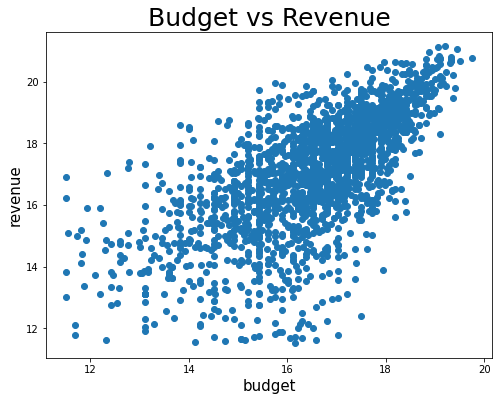

In [0]:
plt.figure(figsize=[8,6])
plt.scatter(np.log(copy_df['budget']),np.log(copy_df['revenue']))
plt.xlabel('budget', size=15)
plt.ylabel('revenue', size=15)
plt.title('Budget vs Revenue', size=25)
plt.show()

The graph above is showing the correlation of budget to revenue with no extreme outliers.

## Cleaning non-integer columns

### Year column

First I will check if there are any null values in the release_date column and them confirm if they are strings like we saw above. Then I will use a pd.datetime function to convert them to a useable format.

In [0]:
print('Does release date have null values',':',copy_df['release_date'].isnull().any())
print(type(copy_df['release_date'][0]))

Does release date have null values : False
<class 'str'>


In [0]:
import datetime
copy_df['year_released']= pd.DatetimeIndex(copy_df['release_date']).year

1970
2069


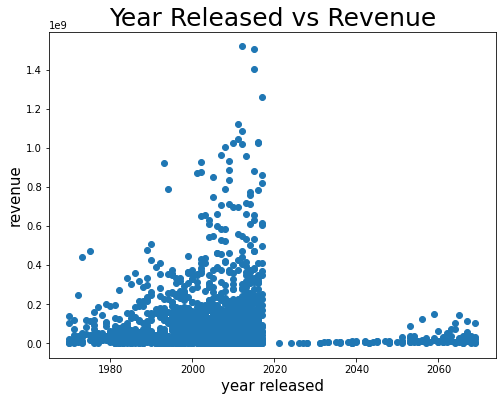

In [0]:
print(copy_df['year_released'].min())
print(copy_df['year_released'].max())
plt.figure(figsize=[8,6])
plt.scatter(copy_df['year_released'],copy_df['revenue'])
plt.xlabel('year released', size=15)
plt.ylabel('revenue', size=15)
plt.title('Year Released vs Revenue', size=25)
plt.show()

The graph above shows us that we have a couple of movies with dates after 2020 so I will remove those outliers

In [0]:
copy_df = copy_df[copy_df['year_released']<=2020]
copy_df['year_released'].max()

2017

### Run-time column

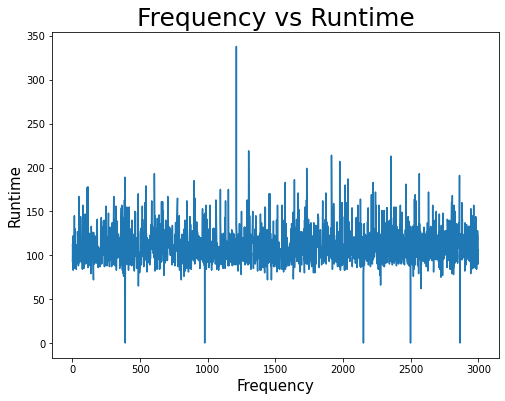

In [0]:
plt.figure(figsize=[8,6])
plt.plot(copy_df['runtime'])
plt.xlabel('Frequency', size=15)
plt.ylabel('Runtime',size=15)
plt.title('Frequency vs Runtime',size=25)
plt.show()

This graph above shows that we have some 0 run time movies ,I will just remove all the 0 runtime movies.

In [0]:
copy_df = copy_df[copy_df['runtime']>1]
copy_df['runtime'].min()

62.0

### Cleaning genres column

Now to clean the columns with the jshon like text 

In [0]:
copy_df['genres'][1]

"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]"

In [0]:
def genres_preprocessing(elem):
    if pd.isnull(elem):
        str1 = ' '
    else:
        str1 = elem.replace(']','').replace('[','').replace('{','').replace('}','').replace('\'','').replace(' ','').replace('name','').replace('id','').replace(':','')#.replace(' ','|')
        one = str1.split(',')[1::2]
        str1 = ''
        for x in one:
            str1+= x + '|'
    return str1[:-1]

In [0]:
print(genres_preprocessing(copy_df.genres[1]))
print(type(genres_preprocessing(copy_df.genres[1])))

Comedy|Drama|Family|Romance
<class 'str'>


Now that I picked the genres from the jshon like text, I will apply the cleaning function to my dataframe.

In [0]:
copy_df['genres_processed'] = copy_df.genres.apply(lambda elem: genres_preprocessing(elem))

In [0]:
copy_df['genres_processed'][1]

'Comedy|Drama|Family|Romance'

In [0]:
genres_cleaned= copy_df.genres_processed.str.split('|',expand=True).stack()
print(genres_cleaned)

0     0      Comedy
1     0      Comedy
      1       Drama
      2      Family
      3     Romance
             ...   
2998  0      Comedy
      1     Romance
2999  0    Thriller
      1      Action
      2     Mystery
Length: 5149, dtype: object


Now I can make dummies and paste it on to my dataframe

In [0]:
genres_dummies = pd.get_dummies(genres_cleaned, prefix='g').groupby(level=0, sort=False).sum()
print(genres_dummies.shape)
print(copy_df.shape)

(1964, 21)
(1964, 25)


In [0]:
copy_df = pd.concat([copy_df, genres_dummies], axis=1)
copy_df.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,year_released,genres_processed,g_,g_Action,g_Adventure,g_Animation,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Family,g_Fantasy,g_Foreign,g_History,g_Horror,g_Music,g_Mystery,g_Romance,g_ScienceFiction,g_TVMovie,g_Thriller,g_War,g_Western
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,2015,Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Cleaning production companies column

Taking a look at production companies there are alot of them per movie so I will unstack them and make dummies.I will leave the code to convert them in to dummies below to show a way to add them to your model.  
Update! after running my model I have decided to remove production companies because since there are so many it doesnt sway my model as much as I would like.

In [0]:
copy_df['production_companies'][2]

"[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]"

This function production_companies_preprocessing replaces all the rand characters in the column and takes the production companies names"""

In [0]:
def production_companies_preprocessing(elem):
    str3 = ''
    if pd.isnull(elem):
        two = ''
    else :
        str2 = elem.replace(']','').replace('[','').replace('{','').replace('}','').replace('\'','').replace('name','').replace('id','').replace(':','').replace('.','').replace('nan', 'none').replace(' ','')
        two = str2.split(',')[0::2]
    for x in two:
        str3+= x + '|'
    return str3[:-1]

1)copy_df['production_companies_processed'] = copy_df.production_companies.apply(lambda elem: production_companies_preprocessing(elem))   
2)print(copy_df['production_companies_processed'])   
3)production_companies_processed= copy_df.production_companies_processed.str.split('|',expand=True).stack()
4)print(copy_df['production_companies_processed'])   
5)production_companies_dummies = pd.get_dummies(production_companies_processed, prefix='p').groupby(level=0, sort=False).sum()
6)print(production_companies_dummies.shape)   
7)print(copy_df.shape)


### Cleaning belongs_to_collection

So I will take the belongs_to_collection columns and convert them into floats so they can fit in my model. 1= series 0=non-series.

In [0]:
def string_to_1(elem):
  if isinstance(elem,str):
    word = 1
  else:
    word = 0
  return word

In [0]:
copy_df['belongs_to_collection_processed'] = copy_df.belongs_to_collection.apply(lambda elem: string_to_1(elem))
print(copy_df['belongs_to_collection_processed'])
print(type(copy_df['belongs_to_collection_processed'][1]))

0       1
1       1
2       0
3       0
5       0
       ..
2991    1
2993    0
2997    0
2998    0
2999    0
Name: belongs_to_collection_processed, Length: 1964, dtype: int64
<class 'numpy.int64'>


### Cleaning crew to retrieve director

To clean my director column I created a function called field extract that skips nulls,replaces brackets,then extracts a value associated with the dict key.ex(jobName)'''

In [0]:
data['crew'].isnull().any()

True

In [0]:
import ast
elem = data.crew[0]
jobName = 'job'
jobTitle = 'Director'
fieldName = 'name'

In [0]:
def field_extract(elem, jobName, jobTitle, fieldName):
  nullColumn = pd.isnull(elem)
  if nullColumn:
    newoutputs = ''
  else:
    newoutputs = ''
    string = elem.replace(']','').replace('[','')
    res = ast.literal_eval(string)
    outputs = []
    if isinstance(res,dict):
        if res[jobName]==jobTitle:
            outputs.append(res[fieldName])
    else:
        for idx in (np.arange(0,(len(res)-1))):
          if res[idx][jobName]==jobTitle:
              outputs.append(res[idx][fieldName])
        for x in outputs:
            newoutputs+= str(x) 
  return newoutputs

In [0]:
copy_df['director_processed'] = copy_df.crew.apply(lambda elem: field_extract(elem, 'job', 'Director','name')) 

In [0]:
print(type(copy_df['director_processed'][1]))
print(copy_df['director_processed'].isnull().any())

<class 'str'>
False


I will noe make my directors into numerical indexs so my decision tree can accept the variable

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(copy_df['director_processed'])
copy_df['director_processed_1'] = le.transform(copy_df['director_processed'])

In [0]:
print(copy_df['director_processed_1'].value_counts())
print(copy_df.director_processed.value_counts())

0       74
1054    10
197      9
1053     8
135      8
        ..
685      1
684      1
682      1
681      1
585      1
Name: director_processed_1, Length: 1171, dtype: int64
                      74
Steven Spielberg      10
Clint Eastwood         9
Steven Soderbergh      8
Paul W.S. Anderson     8
                      ..
B Unnikrishnan         1
Geoff Burrowes         1
Henry Selick           1
John Bonito            1
Stacy Peralta          1
Name: director_processed, Length: 1171, dtype: int64


### Cleaning home page column

Since the homepage column is identical I have double usage of my string_to_1 function!And this column can go into my decision tree model as well.

In [0]:
copy_df['homepage']

0                                        NaN
1                                        NaN
2          http://sonyclassics.com/whiplash/
3                 http://kahaanithefilm.com/
5                                        NaN
                        ...                 
2991                                     NaN
2993    http://www.theterminal-themovie.com/
2997                                     NaN
2998          http://www.alongcamepolly.com/
2999        http://www.abductionthefilm.com/
Name: homepage, Length: 1964, dtype: object

In [0]:
copy_df['homepage_processed'] = copy_df.homepage.apply(lambda elem: string_to_1(elem))
print(copy_df['homepage_processed'])

0       0
1       0
2       1
3       1
5       0
       ..
2991    0
2993    1
2997    0
2998    1
2999    1
Name: homepage_processed, Length: 1964, dtype: int64


### Cleaning the original language column

So since the original language column is clean I use a label encoder and change the languages to numbers for my decision tree model.

In [0]:
copy_df['original_language'][0]

'en'

In [0]:
print('Does original_language have nulls' ,':',copy_df['original_language'].isnull().any())
copy_df['original_language'].value_counts()

Does original_language have nulls : False


en    1747
hi      37
fr      32
ru      24
ja      17
es      16
zh      14
ta      12
de       9
ko       9
it       8
cn       8
pt       4
nl       3
ro       2
da       2
pl       2
te       2
ml       2
sv       2
fi       2
tr       1
fa       1
nb       1
hu       1
he       1
mr       1
no       1
ur       1
id       1
vi       1
Name: original_language, dtype: int64

In [0]:
le.fit(copy_df['original_language'])
copy_df['original_language_processed'] = le.transform(copy_df['original_language'])
print(copy_df['original_language_processed'].value_counts())

3     1747
9       37
7       32
23      24
13      17
4       16
30      14
25      12
14       9
2        9
12       8
0        8
21       4
18       3
1        2
26       2
6        2
24       2
22       2
20       2
15       2
11       1
10       1
17       1
8        1
19       1
5        1
29       1
27       1
28       1
16       1
Name: original_language_processed, dtype: int64


## Decision tree/ Random forest models

### Finding correlation 
To show all the columns that have correlations that I want to put into my decision tree I want to see what numerical columns have correlation 

In [0]:
corr_matrix = copy_df.corr()
print(corr_matrix['revenue'].sort_values(ascending=False))

revenue                            1.000000
budget                             0.733327
popularity                         0.436635
belongs_to_collection_processed    0.351038
g_Adventure                        0.340915
homepage_processed                 0.260964
runtime                            0.224280
g_Fantasy                          0.176081
g_Action                           0.173657
g_Family                           0.172102
g_Animation                        0.141075
year_released                      0.133541
g_ScienceFiction                   0.124025
g_Western                          0.005667
id                                -0.005669
g_TVMovie                         -0.007467
director_processed_1              -0.017419
g_War                             -0.025872
g_                                -0.026178
g_Thriller                        -0.026240
g_Music                           -0.029995
g_Foreign                         -0.034466
g_Mystery                       

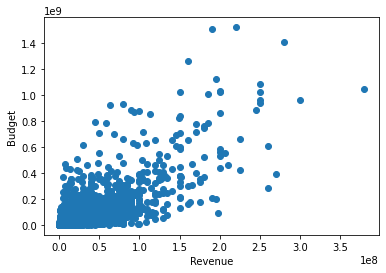

In [0]:
plt.scatter(copy_df['budget'], copy_df['revenue'])
plt.xlabel('Revenue')
plt.ylabel('Budget')
plt.show()

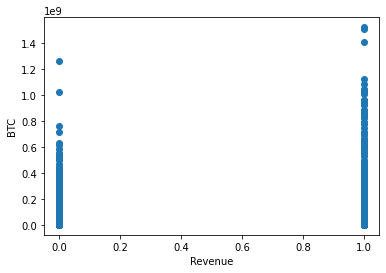

In [0]:
plt.scatter(copy_df['belongs_to_collection_processed'], copy_df['revenue'])
plt.xlabel('Revenue')
plt.ylabel('BTC')
plt.show()

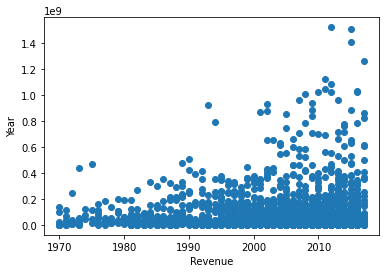

In [0]:
plt.figure(figsize=[6,4])
plt.scatter(copy_df['year_released'],copy_df['revenue'])
plt.xlabel('Revenue')
plt.ylabel('Year')
plt.show()

These graphs above are plot of columns correlated to revenue, I believe 

### Building a decision tree model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [0]:
copy_df.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,year_released,genres_processed,g_,g_Action,g_Adventure,g_Animation,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Family,g_Fantasy,g_Foreign,g_History,g_Horror,g_Music,g_Mystery,g_Romance,g_ScienceFiction,g_TVMovie,g_Thriller,g_War,g_Western,belongs_to_collection_processed,director_processed,director_processed_1,homepage_processed,original_language_processed
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,2015,Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Steve Pink,1045,0,3


In [0]:
model_df = copy_df.drop(columns=['id', 'belongs_to_collection','genres','homepage','imdb_id','original_language','original_title',
                                 'overview','poster_path','production_companies','production_countries','release_date',
                                 'spoken_languages','status','tagline','title','Keywords','cast','crew','genres_processed',
                                 'g_','director_processed','popularity'])

In [0]:
model_df.isnull().sum()

budget                             0
runtime                            0
revenue                            0
year_released                      0
g_Action                           0
g_Adventure                        0
g_Animation                        0
g_Comedy                           0
g_Crime                            0
g_Documentary                      0
g_Drama                            0
g_Family                           0
g_Fantasy                          0
g_Foreign                          0
g_History                          0
g_Horror                           0
g_Music                            0
g_Mystery                          0
g_Romance                          0
g_ScienceFiction                   0
g_TVMovie                          0
g_Thriller                         0
g_War                              0
g_Western                          0
belongs_to_collection_processed    0
director_processed_1               0
homepage_processed                 0
o

In [0]:
model_df.head()

,budget,runtime,revenue,year_released,g_Action,g_Adventure,g_Animation,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Family,g_Fantasy,g_Foreign,g_History,g_Horror,g_Music,g_Mystery,g_Romance,g_ScienceFiction,g_TVMovie,g_Thriller,g_War,g_Western,belongs_to_collection_processed,director_processed_1,homepage_processed,original_language_processed
0,14000000,93.0,12314651,2015,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1045,0,3
1,40000000,113.0,95149435,2004,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,346,0,3
2,3300000,105.0,13092000,2014,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,212,1,3
3,1200000,122.0,16000000,2012,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1062,1,9
5,8000000,83.0,3261638,1987,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,403,0,3


I am going to process my revenue in my budget so that my decision tree model works better.

In [0]:
model_df['revenue'] = np.log1p(model_df['revenue'])
model_df['budget'] = np.log1p(model_df['budget'])

In [0]:
model_df.head()

,budget,runtime,revenue,year_released,g_Action,g_Adventure,g_Animation,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Family,g_Fantasy,g_Foreign,g_History,g_Horror,g_Music,g_Mystery,g_Romance,g_ScienceFiction,g_TVMovie,g_Thriller,g_War,g_Western,belongs_to_collection_processed,director_processed_1,homepage_processed,original_language_processed
0,16.454568,93.0,16.326300,2015,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1045,0,3
1,17.504390,113.0,18.370959,2004,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,346,0,3
2,15.009433,105.0,16.387512,2014,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,212,1,3
3,13.997833,122.0,16.588099,2012,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1062,1,9
5,15.894952,83.0,14.997740,1987,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,403,0,3


In [0]:
X = model_df.drop('revenue',axis=1)
y = model_df['revenue']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42,shuffle=True)

In [0]:
y_pred = model.predict(X_test)
def rmse(y_pred, y_true):
  return np.sqrt(mean_squared_error(y_pred,y_true))

In [0]:
model= DecisionTreeRegressor(max_depth=15, random_state=42)
model.fit(X_train, y_train)
model_score = model.score(X_train, y_train)
print('Decision Tree Model Accuracy', ':',model_score)

Decision Tree Model Accuracy : 0.9563764261246462


In [0]:
import graphviz
from IPython.display import display
from sklearn import tree

display(graphviz.Source(tree.export_graphviz(model, feature_names=model_df.drop('revenue',axis=1).columns)))

This score is great and shows that our model variables were able to predict around .94 on our training set but lets try a random forest to see if we can improve our RMSE

## Random Forest Regressor
This is a random forest regressor where we take mutiple random trees and select the best routes for classification for our decision model! 

In [0]:
y_pred = model.predict(X_test)
def rmse(y_pred, y_true):
  return np.sqrt(mean_squared_error(y_pred,y_true))
def print_rf_score(model):
  print(f'Train R2: {model.score(X_train,y_train)}')
  print(f'Valid R2: {model.score(X_test,y_test)}')
  print(f'Train RMSE: {rmse(model.predict(X_train),y_train)}')
  print(f'Valid RMSE: {rmse(model.predict(X_test),y_test)}')

In [0]:
rf = RandomForestRegressor(n_estimators= 20, n_jobs = -1, random_state=0)
rf.fit(X_train, y_train)
print_rf_score(rf)

Train R2: 0.913047517969533
Valid R2: 0.4889656282820337
Train RMSE: 0.5475767845284238
Valid RMSE: 1.3833812600138005


In [0]:
TreeCount = 20
percErrRF_total = np.zeros(TreeCount)
for x in np.arange(1,TreeCount,1):
  numLoops = 15
  percErrRF    = np.zeros(numLoops)
  for inX in np.arange(1,numLoops,1):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
    rfModel = RandomForestRegressor(n_estimators=x, random_state=0)
    rfModel.fit(X_train, y_train)
    y_predRF        = rfModel.predict(X_test)
    percErrRF[inX]  = np.mean(np.abs(y_predRF-y_test)/y_test)*100
  print(str(x) + ' trees finished')
  percErrRF_total[x] = np.mean(percErrRF)

1 trees finished
2 trees finished
3 trees finished
4 trees finished
5 trees finished
6 trees finished
7 trees finished
8 trees finished
9 trees finished
10 trees finished
11 trees finished
12 trees finished
13 trees finished
14 trees finished
15 trees finished
16 trees finished
17 trees finished
18 trees finished
19 trees finished


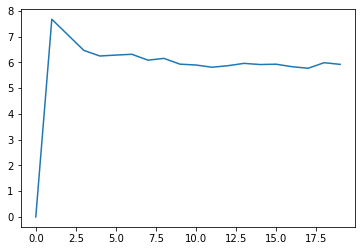

In [0]:
plt.plot(percErrRF_total)

The plot above shows that after about 2.5 trees the percent error hovers around a percent error 6.5 meaning our model does a good job at predicting across multiple iterations. This is great, the Random Forest Regressor worked better as a model for predicting movie prices!